<a href="https://colab.research.google.com/github/deepskies/DeepSLEEP/blob/main/Analysis/5_param_analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lensing summary statistics with a neural net
This is a simulation-based inference of lensing parameters, based on [this notebook](https://github.com/mackelab/sbi/blob/main/tutorials/05_embedding_net.ipynb). The simulator model generates high-dimensional (32 by 32 images) lensing images and we use a convolutional neural network as summary statistics extractor.

---

`sbi` offers functionality to learn summary statistics from (potentially high-dimensional) simulation outputs with a neural network. In `sbi`, this neural network is referred to as `embedding_net`. If an `embedding_net` is specified, the simulation outputs are passed through the `embedding_net`, whose outputs are then passed to the neural density estimator. The parameters of the `embedding_net` are learned together with the parameters of the neural density estimator.

First of all, we import all the packages required for running the tutorial.

**Deeplenstronomy configuration template files can be found in the github folder deeplenstronomy_templates**

We use the lenstronomy package to simulate lenses.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/Colab Notebooks/SBI
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SBI
12_BNN_pos_gauss1.pdf
12_BNN_pos_gauss2.pdf
12_BNN_pos_gauss3.pdf
12_BNN_pos.pdf
12_BNN_test.pdf
12param_BNN_1mil.pkl
12param_BNN_500k.pkl
12param_BNN_800k2.pkl
12param_BNN_800k3.pkl
12param_BNN_800k_42.pkl
12param_BNN_800k_465_gauss1.pkl
12param_BNN_800k_465_gaussian2.pkl
12param_BNN_800k_465_gaussian_3.pkl
12param_BNN_800k_465_gaussian.pkl
12param_BNN_800k_839.pkl
12param_BNN_800k.pkl
12param_BNN_800_test.pkl
12param_BNN_gauss1.pkl
12param_BNN_gauss2.pkl
12param_BNN_gauss3.pkl
12param_BNN.pkl
12param_corner_465.pdf
12_parameter_corner_42.pdf
12_parameter_corner_465.pdf
12_parameter_npe_summary_seed42.pkl
12param_model_1.pkl
12param_model_400_20_42.pkl
12param_model_400k_100hf_20nt_Jason.pkl
12param_model_42_0.pkl
12param_model_42_1.pkl
12param_model_42_1_redo.pkl
12param_model_42_2.pkl
12param_model_42_2_redo.pkl
12param_model_42_3.pkl
12param_model_42_3_redo.pkl
12param_model_42_4_redo.pkl
12param_model_500k_1000hf

In [2]:
!pip install sbi==0.22.0 --quiet
!pip install lenstronomy --quiet
!pip install deeplenstronomy==0.0.2.3 --quiet
!pip install getdist --quiet
!pip install -q gwpy --quiet
!apt-get update
!sudo apt-get install texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra cm-super dvipng --quiet --fix-missing
!pip uninstall pandas -y --quiet
!pip install pandas==1.5.3 --quiet
!pip uninstall tensorflow -y --quiet
!pip install tensorflow==2.9.1 --quiet
!pip install tensorflow_probability==0.17.0 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.6/826.6 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.0

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils, inference
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
import numpy as np
import scipy as sp
from scipy import stats
import getdist
from getdist import plots, MCSamples
from getdist.styles.tab10 import style_name
plots.set_active_style(style_name)

# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.image_util as image_util
from lenstronomy.Data.psf import PSF

# set seed for numpy and torch
import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image

# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse
import pickle
#from chainconsumer import ChainConsumer

# Colab in order to download files
from google.colab import files


# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp

#import deeplenstronomy.deeplenstronomy as dl
#from deeplenstronomy.visualize import view_image

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pandas
import copy


# Matplotlib, seaborn and plot pretty
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
# rcParams['font.family'] = 'serif'
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from mpl_toolkits.axes_grid1 import make_axes_locatable
#
# # Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=12):
    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines
    return

plot_pretty()

# Pillow
from PIL import Image

#fix seed
np.random.seed(100)

# 1. Loading the trained model

We load our trained model.

In [4]:
class SummaryNet(nn.Module):

   def __init__(self):
       super().__init__()
       # 2D convolutional layer
       self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same')
       self.bn1 = nn.BatchNorm2d(8)
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
       self.bn2 = nn.BatchNorm2d(16)

       self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
       self.bn3 = nn.BatchNorm2d(32)
       self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
       self.bn4 = nn.BatchNorm2d(32)

       self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
       self.bn5 = nn.BatchNorm2d(64)
       self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
       self.bn6 = nn.BatchNorm2d(128)

       # Maxpool layer that reduces 32x32 image to 4x4
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
       self.fc = nn.Linear(in_features=128*4*4, out_features=20)

   def forward(self, x):
       x = x.view(-1, 1, 32, 32)

       x = (self.bn1(F.relu(self.conv1(x))))
       x = self.pool(self.bn2(F.relu(self.conv2(x))))

       x = self.bn3(F.relu(self.conv3(x)))
       x = self.pool(self.bn4(F.relu(self.conv4(x))))

       x = self.bn5(F.relu(self.conv5(x)))
       x = self.pool(self.bn6(F.relu(self.conv6(x))))

       x = x.view(-1, 128*4*4)
       x = F.relu(self.fc(x))
       return x

embedding_net = SummaryNet().to('cuda:0')

from torchsummary import summary
summary(embedding_net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
            Conv2d-3           [-1, 16, 32, 32]           1,168
       BatchNorm2d-4           [-1, 16, 32, 32]              32
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
       BatchNorm2d-7           [-1, 32, 16, 16]              64
            Conv2d-8           [-1, 32, 16, 16]           9,248
       BatchNorm2d-9           [-1, 32, 16, 16]              64
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
      BatchNorm2d-12             [-1, 64, 8, 8]             128
           Conv2d-13            [-1, 128, 8, 8]          73,856
      BatchNorm2d-14            [-1, 12

In [8]:
file_name = "../SBI_WG/Jason/400k_5param_Ashwin_rep_run_seed465_of20_hf120_nt20_bs100.pkl"

open_file = open(file_name, "rb")
pos_list465 = pickle.load(open_file)
open_file.close()


AttributeError: Can't get attribute 'SummaryNet' on <module '__main__'>

# 2. Simulated-Based Calibration Diagnostics

Now let's run some diagnostics. First we make Simulation-Based Calibration diagnostics, following:


https://www.mackelab.org/sbi/tutorial/13_diagnostics_simulation_based_calibration/


First, we load the training data:

In [31]:
file_name = "../SBI_WG/Jason/5param_model_training_500k_Aug29.pkl"
open_file = open(file_name, "rb")
dataset = pickle.load(open_file)
open_file.close()

training_set_size = 400000
theta_E = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][:training_set_size]
le1 = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'][:training_set_size]
le2 = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'][:training_set_size]
x = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'][:training_set_size]
y = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'][:training_set_size]

images = torch.cuda.FloatTensor(dataset.CONFIGURATION_1_images[:training_set_size].reshape(training_set_size,1,1024))[:,0]
theta = torch.cuda.FloatTensor(np.array([theta_E,le1,le2,x,y]).T)
parameter_labels=[r'$\theta_E$',r'$l_{e1}$',r'$l_{e2}$',r'$x$',r'$y$']

In [35]:
cov = np.cov(theta.cpu().T)
print(cov.tolist())

[[1.144292672305244, -0.00032099426289209255, 0.0008591411642163255, 0.001786609976363722, -0.0009547140518171146], [-0.00032099426289209255, 0.21320738546315254, -0.0005512953063048074, -0.00024505073908153086, 0.0005875512583767902], [0.0008591411642163255, -0.0005512953063048074, 0.21355690491633644, 0.0011119166457131291, 8.254697102910096e-05], [0.001786609976363722, -0.00024505073908153086, 0.0011119166457131291, 1.3374574789758593, 0.00017720721198029413], [-0.0009547140518171146, 0.0005875512583767902, 8.254697102910096e-05, 0.00017720721198029413, 1.333259374076836]]


In [24]:
#Simulation-Based Calibration
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc,run_sbc, get_nltp, sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

num_sbc_runs = 1000 # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
num_posterior_samples = 1000

thetas = theta[:num_sbc_runs]
xs = images[:num_sbc_runs]

ranks_465, dap_samples_465 = run_sbc(thetas, xs, pos_list465[0], num_posterior_samples=num_posterior_samples)
check_stats_465 = check_sbc(ranks_465.cpu(), thetas.cpu(), dap_samples_465.cpu(), num_posterior_samples=num_posterior_samples)



Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

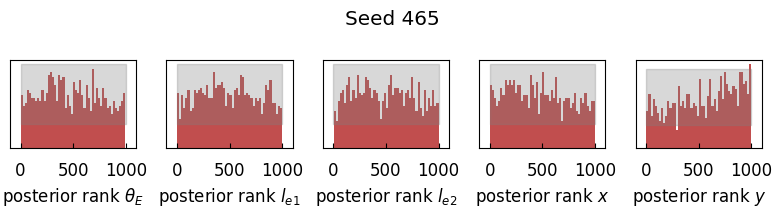

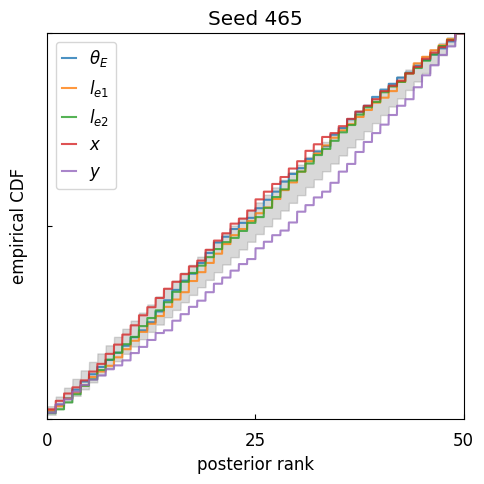

In [25]:
f,ax=sbc_rank_plot(ranks=ranks_465.cpu(),num_posterior_samples=num_posterior_samples,
             plot_type="hist",
             num_bins=None,parameter_labels=parameter_labels, ranks_labels=[''], figsize = (8,2.2), kwargs={'num_cols':5})
plt.suptitle('Seed 465')
plt.tight_layout()
plt.savefig('5_param_npe_pos_465_sbc_hist.pdf', format='pdf')

f, ax = sbc_rank_plot(ranks_465.cpu(), num_sbc_runs, plot_type = "cdf",parameter_labels=parameter_labels, figsize = (5,5))
plt.title('Seed 465')
plt.tight_layout()
plt.savefig('5_param_npe_pos_465_sbc_cdf.pdf', format='pdf')

# 3. NPE Posterior Coverage Plot


The next diagnostic plot we make is a posterior coverage distribution plot. This plot tells us if our trained neural posterior estimator (NPE) accurately predicts the true uncertainties of the data. In such plots, the x-axis shows different confidence intervals of the posterior volume, and the y-axis shows the fraction of the lenses' true parameter values that fall within that posterior volume. A perfectly calibrated plot should have a line that traces x=y.  

First, we generate our test set. We will also generate a second set with the same parameters but Einstein ring set to zero to get the unlensed source image.



In [9]:
config_file = '../SBI_WG/5param_model_test.yaml'
test_set = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/5param_model_test-gaussian.yaml'
test_set_gaussian = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/5param_model_test-gaussian2.yaml'
test_set_gaussian2 = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/5param_model_test-gaussian3.yaml'
test_set_gaussian3 = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/12_model_test_des_real_source.yaml'
source_set = dl.make_dataset(config_file, return_planes=True)

Now, we produce data for the posterior coverage plot. The below covariance matrix was calculated from the training set data, but for convenience the numbers have been precalculated.

In [36]:
cov = [[1.144292672305244, -0.00032099426289209255, 0.0008591411642163255, 0.001786609976363722, -0.0009547140518171146], [-0.00032099426289209255, 0.21320738546315254, -0.0005512953063048074, -0.00024505073908153086, 0.0005875512583767902], [0.0008591411642163255, -0.0005512953063048074, 0.21355690491633644, 0.0011119166457131291, 8.254697102910096e-05], [0.001786609976363722, -0.00024505073908153086, 0.0011119166457131291, 1.3374574789758593, 0.00017720721198029413], [-0.0009547140518171146, 0.0005875512583767902, 8.254697102910096e-05, 0.00017720721198029413, 1.333259374076836]]


In [38]:
%%capture

test_number = 1000

true_theta_E = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]
true_array = np.array([true_theta_E, true_le1, true_le2, true_x, true_y])

x_observed = torch.tensor(test_set.CONFIGURATION_1_images.reshape(1000,1,1024),dtype=torch.float32)[:,0]
x_observed = torch.tensor(x_observed, dtype=torch.float32)

def calculate_coverage_fraction(x_observed, pos_list, truth_array, percentile_list, test_number=100, sample_number = 1000):
  count_array = []
  for i in range(test_number):
    samples = pos_list[0].set_default_x(x_observed[i]).sample((sample_number,),show_progress_bars=False)
    count_vector = []
    for ind, cov in enumerate(percentile_list):
      percentile_l = 50.0 - cov/2
      percentile_u = 50.0 + cov/2
      confidence_l = np.percentile(samples.cpu(),percentile_l,axis=0)
      confidence_u = np.percentile(samples.cpu(),percentile_u,axis=0)
      count = np.logical_and(confidence_u - truth_array.T[i] > 0, truth_array.T[i] - confidence_l > 0)
      count_vector.append(count)
    count_array.append(count_vector)
  count_sum_array = np.sum(count_array, axis=0)
  frac_lens_within_vol = np.array(count_sum_array)
  return np.array(frac_lens_within_vol).T/sample_number

def distance(param_vector, mean_vector, covariance):
  d = np.array(param_vector-mean_vector)
  return d.dot(covariance).dot(d.T)

def calculate_coverage_fraction_distance_2(x_observed, pos_list, truth_array, percentile_list, covariance, test_number=100, sample_number = 1000):
  count_array = []
  for i in range(test_number):
    samples = pos_list[0].set_default_x(x_observed[i]).sample((sample_number,),show_progress_bars=False).cpu()
    count_vector = []
    mean = np.median(samples, axis=0)
    for ind, percentile in enumerate(percentile_list):
      d = distance(samples, mean, covariance)
      d_true = distance(truth_array[:,i], mean, covariance)
      d_array = d.diagonal()
      # difference = abs(np.array(samples)-mean)
      # difference_true = abs(.T[i]-mean)
      confidence_l = np.percentile(d_array, percentile, axis=0)
      count = confidence_l - d_true > 0
      count_vector.append(count)
    count_array.append(count_vector)
  return np.sum(np.array(count_array), axis=0)/len(samples)

percentile_array = np.linspace(0,100,21)
# cov = np.cov(theta[:10000].T)
# print(f"{cov}")

In [40]:
frac_array465 = calculate_coverage_fraction(x_observed, pos_list465, true_array, percentile_array, test_number)
cov = np.cov(true_array)
frac_array465_combined = calculate_coverage_fraction_distance_2(x_observed, pos_list465, true_array, percentile_array, cov, test_number)


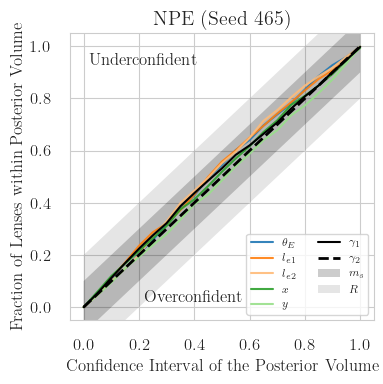

In [42]:
percentile_array = np.linspace(0,100,21)
percentile_array_norm = np.array(percentile_array)/100

from cycler import cycler

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (140, 86, 75),
             (227, 119, 194), (23, 190, 207), (158, 218, 229)]

#(174, 199, 232)

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

default_cycler = (cycler(color=tableau20) + cycler(linestyle=['-','-','-','-','-',':',':','--','--','--','--','--']))

plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)

sns.set_style("whitegrid")
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.plot(percentile_array_norm, frac_array465.T, alpha = .9)
plt.plot(percentile_array_norm, frac_array465_combined, c = 'k',ls='-')
plt.plot([0,0.5,1],[0,0.5,1], 'k--', lw=2, zorder=1000)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.1,
    y2=percentile_array_norm+0.1,
    color='k',
    edgecolor="none",
    alpha=0.2,)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.2,
    y2=percentile_array_norm+0.2,
    color='k',
    edgecolor="none",
    alpha=0.1,)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.text(0.02,0.93,'Underconfident', fontsize=12, horizontalalignment='left')
plt.text(0.22,0.02,'Overconfident',fontsize =12, horizontalalignment='left')
plt.legend([r'$\theta_E$',r'$l_{e1}$',r'$l_{e2}$',r'$x$',r'$y$',r'$\gamma_1$',r'$\gamma_2$',r'$m_s$',r'$R$',r'$n$',r'$s_{e1}$',r'$s_{e2}$',r'$D$'],prop={'size': 8},ncol=2,loc=4)
plt.xlabel('Confidence Interval of the Posterior Volume')
plt.ylabel('Fraction of Lenses within Posterior Volume')
plt.title('NPE (Seed 465)')
plt.tight_layout()
plt.savefig('5_param_npe_pos_465_v2.pdf', format='pdf')

# 4. Accuracy and Precision of the max-likelihood values of the ensemble.

So far, we've looked at the quality of our posterior volumes. Now, we'll look at the distribution of our max-likelihood values.

In [43]:
%%capture
import gc

x_observed = torch.tensor(test_set.CONFIGURATION_1_images.reshape(1000,1,1024),dtype=torch.float32)[:,0]
x_observed = torch.tensor(x_observed, dtype=torch.float32)

def make_summary_statistic_array(x_observed, posterior, test_number = 1000):

  SBI_median_arr = []
  SBI_max_like_arr = []
  SBI_percentile68u_arr = []
  SBI_percentile68l_arr = []
  SBI_percentile95u_arr = []
  SBI_percentile95l_arr = []
  SBI_sample_array = []
  SBI_logp_array = []
  SBI_map_array = []

  for k in range(len(posterior)):
    # This iterates over multiple SBI networks. If you only have one, len(posterior) should be 1.
    median_arr = []
    max_like_arr = []
    percentile68u_arr = []
    percentile68l_arr = []
    percentile95u_arr = []
    percentile95l_arr = []
    sample_array = []
    logp_array = []
    map_array = []
    for j in range(test_number):
      # This iterates over the number of images in the test set. If you only have one, test_number should be 1.
      median = []
      max_like = []
      percentile68u = []
      percentile68l = []
      percentile95u = []
      percentile95l = []
      samples = posterior[k].set_default_x(x_observed[j]).sample((1000,))
      # map = posterior[k].map(x=x_observed[j])
      # map_array.append(map.cpu().numpy())
      sample_array.append(samples.cpu())
      logp = posterior[k].log_prob(samples)
      logp_array.append(logp.cpu())
      argmaxlogp = torch.argmax(posterior[k].log_prob(samples))
      for i in range(len(samples[0])):
        # This iterates over the number of parameters per image.
        max_like.append(float(samples.cpu()[argmaxlogp][i]))
        median.append(np.median(samples.cpu()[:,i]))
        percentile68l.append(np.percentile(samples.cpu()[:,i],16))
        percentile68u.append(np.percentile(samples.cpu()[:,i],84))
        percentile95l.append(np.percentile(samples.cpu()[:,i],2.5))
        percentile95u.append(np.percentile(samples.cpu()[:,i],97.5))
      median_arr.append(median)
      max_like_arr.append(max_like)
      percentile68l_arr.append(percentile68l)
      percentile68u_arr.append(percentile68u)
      percentile95l_arr.append(percentile95l)
      percentile95u_arr.append(percentile95u)
    SBI_median_arr.append(median_arr)
    SBI_max_like_arr.append(max_like_arr)
    SBI_percentile68u_arr.append(percentile68u_arr)
    SBI_percentile68l_arr.append(percentile68l_arr)
    SBI_percentile95u_arr.append(percentile95u_arr)
    SBI_percentile95l_arr.append(percentile95l_arr)
    SBI_sample_array.append(sample_array)
    SBI_logp_array.append(logp_array)
    # SBI_map_array.append(map_array)

  SBI_median_arr = np.array(SBI_median_arr)
  SBI_max_like_arr = np.array(SBI_max_like_arr)
  SBI_percentile68u_arr = np.array(SBI_percentile68u_arr)
  SBI_percentile68l_arr = np.array(SBI_percentile68l_arr)
  SBI_percentile95u_arr = np.array(SBI_percentile95u_arr)
  SBI_percentile95l_arr = np.array(SBI_percentile95l_arr)
  SBI_sample_array = np.array(SBI_sample_array)
  SBI_logp_array = np.array(SBI_logp_array)
  # SBI_map_array = np.array(SBI_map_array)

  return SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_median_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr

array_dump = make_summary_statistic_array(x_observed, pos_list465, 1000)

import pickle
file_name = "5_parameter_npe_summary_seed465.pkl"
open_file = open(file_name, "wb")
pickle.dump(array_dump, open_file)
open_file.close()

In [24]:
import pickle
file_name = "5_parameter_npe_summary_seed465.pkl"
open_file = open(file_name, "rb")
array_dump = pickle.load(open_file)
open_file.close()

## We want to compare the accuracy and precision of our model to a BNN. Here, we load the BNN model and evaluate its performance on the test set by generating the same summary statistics.

In [6]:
# Define basic numbers
IMAGE_SHAPE = [32, 32, 1]
NUM_TRAIN_EXAMPLES = 500000
NUM_VAL_EXAMPLES = 100000
NUM_TEST_EXAMPLES = 1000
NUM_CLASSES = 5

tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.

kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

def load_model(location):

  model_input = Input(shape=(32,32,1))

  # Convolutional part =================
  # 1st convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 16,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(model_input)
  x = tfp.layers.Convolution2DFlipout(
          filters = 16,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(model_input)
  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # 2nd convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 32,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 32,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # 3rd convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 48,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 48,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # 4th convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 64,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 64,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 64,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)

  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # ====================================
  x = keras.layers.Flatten()(x)
  # ====================================

  x = tfp.layers.DenseFlipout(
          units = 2048,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.tanh)(x)
  x = tfp.layers.DenseFlipout(
          units = 512,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.tanh)(x)
  x = tfp.layers.DenseFlipout(
          units = 64,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.tanh)(x)
  distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(5))(x)
  model_output = tfp.layers.MultivariateNormalTriL(event_size=5)(distribution_params)
  model = Model(model_input, model_output)

  model.load_weights(location)

  return model

model = load_model('../SBI_WG/Jason/5param_500k_100k_500epochs_BNN.h5')

In [10]:
def make_summary_statistic_BNN(test_set, model, test_number = 1000):
  pred_array = []
  X_0 = test_set.CONFIGURATION_1_images
  X_0 = np.moveaxis(X_0,1,-1)[:test_number]

  n_rands = 100
  pred_dist = model(X_0)
  sample= np.asarray(pred_dist.sample(n_rands))
  for i in range(n_rands):
    pred_dist = model(X_0)
    sample_loc = np.asarray(pred_dist.sample(n_rands))
    sample = np.concatenate((sample,sample_loc))
  return sample

BNNsamples = make_summary_statistic_BNN(test_set, model, test_number = 1000)


In [11]:
import pickle
file_name = "5param_BNN_paper.pkl"
open_file = open(file_name, "wb")
pickle.dump(BNNsamples, open_file)
open_file.close()


In [13]:
file_name = "5param_BNN_paper.pkl"
open_file = open(file_name, "rb")
BNNsamples = pickle.load(open_file)
open_file.close()

## Finally, we put the NPE and BNN inference statistics together and make a ensemble diagnostic plot.

In [28]:
SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_best_fit_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr = array_dump
test_number = 1000
prior_low = [0.3, -0.8, -0.8, -2, -2, -0.6, -0.6, 22, 0.1, 0.5, -0.8, -0.8]
prior_high = [4.0, 0.8, 0.8, 2, 2, 0.6, 0.6, 27, 3, 8, 0.8, 0.8]

prior_low = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
prior_high = [1,1,1,1,1,1,1,1,1,1,1,1]

limits = np.array([prior_low, prior_high]).T

true_theta_E = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]


true_parameter = np.array([true_theta_E, true_le1, true_le2, true_x, true_y])

best_fit_t_diff = SBI_best_fit_arr[0,:test_number,:]-true_parameter.T
max_cut = SBI_max_like_arr[0,:test_number,:]-true_parameter.T
max_cut_ext = np.append(max_cut, SBI_max_like_arr[0,:test_number,:],axis=1)

error = SBI_percentile68u_arr[0,:test_number,:] - SBI_percentile68l_arr[0,:test_number,:]

max_cut_norm = max_cut/error
max_cut_ext_norm = np.append(max_cut_norm, SBI_max_like_arr[0,:test_number,:], axis=1)

pred_med_array = np.median(BNNsamples,axis=0)

BNN_diff = pred_med_array-true_parameter.T

BNN_diff_ext = np.append(BNN_diff, pred_med_array[:test_number,:], axis=1)

BNN_error = np.percentile(BNNsamples,84,axis=0) - np.percentile(BNNsamples,16,axis=0)

BNN_diff_norm = BNN_diff/BNN_error
BNN_diff_ext_norm = np.append(BNN_diff_norm, pred_med_array[:test_number,:], axis=1)

from getdist import plots, MCSamples
from getdist.styles.tab10 import style_name
plots.set_active_style(style_name)

SBIsamples_plot = MCSamples(samples=max_cut_ext,
                       names = [r'\theta_E','le1','le2','x','y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'],
                       labels = [r'\Delta \theta_E','\Delta le1','\Delta le2','\Delta x','\Delta y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'])

SBIsamples_plot_norm = MCSamples(samples=max_cut_ext_norm,
                            names = [r'\theta_E','le1','le2','x','y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'],
                      labels = [r'\theta_E','le1','le2','x','y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'])

BNNsamples_plot = MCSamples(samples=BNN_diff_ext,names = [r'\theta_E','le1','le2','x','y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'],
                       labels = [r'\Delta theta_E','\Delta le1','\Delta le2','\Delta x','\Delta y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'])

BNNsamples_plot_norm = MCSamples(samples=BNN_diff_ext_norm,names = [r'\theta_E','le1','le2','x','y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'],
                       labels = [r'\theta_E','le1','le2','x','y',r'\theta_E_t','le1_t','le2_t','x_t','y_t'])


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [29]:
sns.reset_defaults()

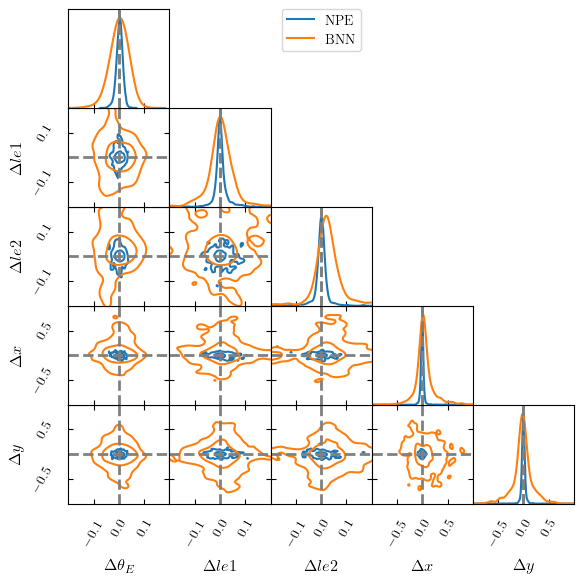

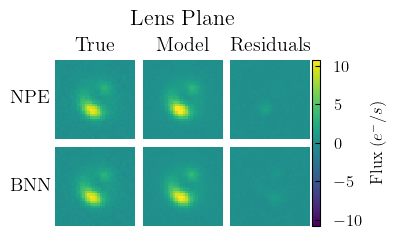

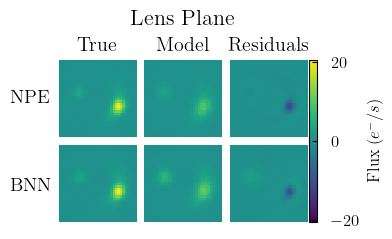

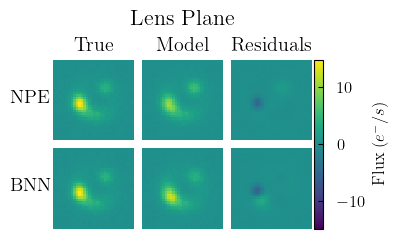

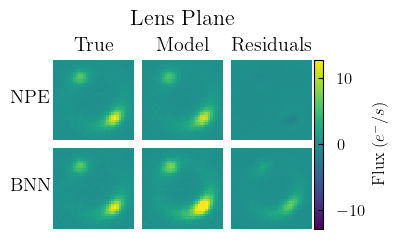

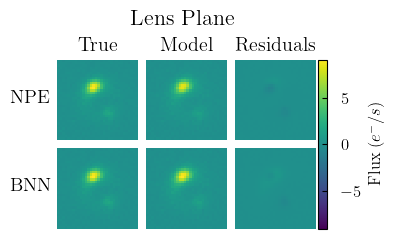

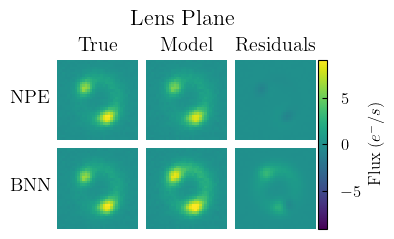

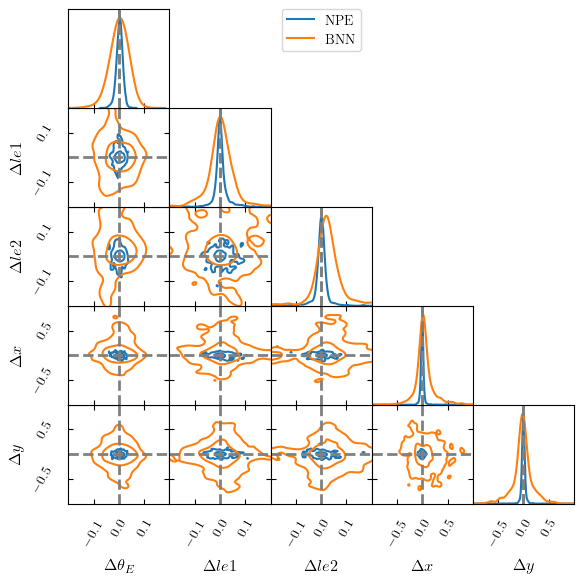

In [32]:
%matplotlib inline
plot_pretty()
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

g = plots.get_subplot_plotter(width_inch=6)
g.settings.axes_fontsize=12
g.settings.axis_tick_x_rotation=60
g.settings.axis_tick_y_rotation=60
g.settings.scaling_factor = 1
g.settings.linewidth=2
g.triangle_plot([SBIsamples_plot,BNNsamples_plot],[r'\theta_E','le1','le2','x','y'], legend_labels=['NPE','BNN'],
                colors=['tab:blue','tab:orange'],
                line_args=[{'color':'tab:blue', 'lw':2},{'color':'tab:orange', 'lw':2}],
                contour_lws = [1.5,1.5],
                markers={r'\theta_E':0,'le1':0,'le2':0,'x':0,'y':0},
                param_limits = {r'\theta_E':[-0.2,0.2],'le1':[-0.2,0.2],'le2':[-0.2,0.2],'x':[-1,1],'y':[-1,1]},
                marker_args ={'lw':2},
                title_limit=0)
for i in range(len(g.subplots[0,:])):
  g.subplots[i,i].axvline(color='gray', ls='--', lw=2)
plt.savefig('5param_corner_%s.pdf'%seed,format='pdf')

# 6. BNN Posterior Coverage


Since we have the BNN model loaded, let's make posterior coverage plots so we can compare the BNN's performance with the NPE model.

In [17]:
test_number = 1000

true_theta_E = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]

true_array = np.array([true_theta_E, true_le1, true_le2, true_x, true_y])
def calculate_coverage_fraction_BNN(samples, truth_array, percentile_list, test_number=100, sample_number = 1000):
  count_vector = []
  for ind, cov in enumerate(percentile_list):
    percentile_l = 50.0 - cov/2
    percentile_u = 50.0 + cov/2
    confidence_l = np.percentile(samples,percentile_l,axis=0)
    confidence_u = np.percentile(samples,percentile_u,axis=0)
    count = np.logical_and(confidence_u - truth_array.T > 0, truth_array.T - confidence_l > 0)
    count_vector.append(count)
  count_sum_array = np.sum(count_vector, axis=1)
  frac_lens_within_vol = np.array(count_sum_array)
  return np.array(frac_lens_within_vol).T/sample_number

def distance(param_vector, mean_vector, covariance):
  d = np.array(param_vector-mean_vector)
  return d.dot(covariance).dot(d.T)

def calculate_coverage_fraction_distance_BNN(input_samples, truth_array, percentile_list, covariance, test_number=100, sample_number = 1000):
  count_array = []
  rng = np.random.default_rng()
  for i in range(test_number):
    samples = rng.choice(input_samples, size=1000, replace=False, axis=0)[:,i,:]
    # samples = input_samples[:1000,i,:]
    count_vector = []
    mean = np.median(samples, axis=0)
    for ind, percentile in enumerate(percentile_list):
      d = distance(samples, mean, cov)
      d_true = distance(truth_array[:,i], mean, covariance)
      d_array = d.diagonal()
      # difference = abs(np.array(samples)-mean)
      # difference_true = abs(.T[i]-mean)
      confidence_l = np.percentile(d_array, percentile, axis=0)
      count = confidence_l - d_true > 0
      count_vector.append(count)
    count_array.append(count_vector)
  return np.sum(np.array(count_array), axis=0)/test_number

percentile_array = np.linspace(0,100,21)

In [19]:
frac_array_BNN = calculate_coverage_fraction_BNN(BNNsamples, true_array, percentile_array, test_number)
cov = [[1.144292672305244, -0.00032099426289209255, 0.0008591411642163255, 0.001786609976363722, -0.0009547140518171146], [-0.00032099426289209255, 0.21320738546315254, -0.0005512953063048074, -0.00024505073908153086, 0.0005875512583767902], [0.0008591411642163255, -0.0005512953063048074, 0.21355690491633644, 0.0011119166457131291, 8.254697102910096e-05], [0.001786609976363722, -0.00024505073908153086, 0.0011119166457131291, 1.3374574789758593, 0.00017720721198029413], [-0.0009547140518171146, 0.0005875512583767902, 8.254697102910096e-05, 0.00017720721198029413, 1.333259374076836]]
frac_array_BNN_com = calculate_coverage_fraction_distance_BNN(BNNsamples, true_array, percentile_array, cov, test_number=1000)
print("frac_array_BNN_com =",frac_array_BNN_com.tolist())
print("frac_array_BNN =",frac_array_BNN.tolist())

frac_array_BNN_com = [0.019, 0.267, 0.388, 0.48, 0.546, 0.592, 0.635, 0.688, 0.735, 0.782, 0.823, 0.857, 0.891, 0.91, 0.939, 0.953, 0.968, 0.979, 0.988, 0.999, 1.0]
frac_array_BNN = [[0.0, 0.126, 0.245, 0.353, 0.469, 0.574, 0.644, 0.737, 0.792, 0.849, 0.893, 0.933, 0.955, 0.974, 0.985, 0.99, 0.994, 0.998, 1.0, 1.0, 1.0], [0.0, 0.113, 0.22, 0.324, 0.425, 0.512, 0.598, 0.667, 0.73, 0.782, 0.834, 0.874, 0.909, 0.928, 0.945, 0.955, 0.969, 0.98, 0.99, 0.996, 1.0], [0.0, 0.08, 0.18, 0.265, 0.348, 0.423, 0.506, 0.549, 0.623, 0.688, 0.738, 0.782, 0.82, 0.854, 0.889, 0.924, 0.943, 0.966, 0.979, 0.989, 1.0], [0.0, 0.078, 0.169, 0.245, 0.323, 0.406, 0.494, 0.572, 0.622, 0.676, 0.728, 0.785, 0.832, 0.878, 0.917, 0.952, 0.969, 0.98, 0.992, 0.998, 1.0], [0.0, 0.072, 0.144, 0.205, 0.286, 0.362, 0.425, 0.484, 0.547, 0.606, 0.663, 0.716, 0.774, 0.822, 0.866, 0.901, 0.939, 0.967, 0.988, 0.999, 1.0]]


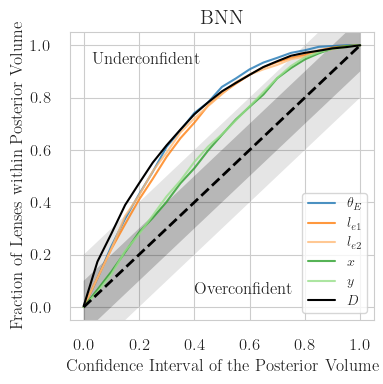

In [20]:
percentile_array_norm = np.array(percentile_array)/100

frac_array_BNN = np.array([[0.0, 0.11, 0.232, 0.338, 0.43, 0.517, 0.612, 0.675, 0.741, 0.782, 0.841, 0.873, 0.908, 0.934, 0.952, 0.971, 0.981, 0.994, 0.997, 1.0, 1.0], [0.0, 0.112, 0.222, 0.317, 0.41, 0.49, 0.574, 0.645, 0.704, 0.77, 0.816, 0.853, 0.887, 0.916, 0.936, 0.952, 0.963, 0.98, 0.991, 0.997, 1.0], [0.0, 0.111, 0.222, 0.348, 0.426, 0.519, 0.59, 0.667, 0.72, 0.768, 0.813, 0.859, 0.888, 0.908, 0.925, 0.947, 0.957, 0.977, 0.985, 0.996, 1.0], [0.0, 0.067, 0.135, 0.21, 0.285, 0.341, 0.402, 0.473, 0.53, 0.598, 0.658, 0.716, 0.765, 0.812, 0.874, 0.913, 0.946, 0.969, 0.988, 0.997, 1.0], [0.0, 0.058, 0.125, 0.214, 0.278, 0.35, 0.423, 0.483, 0.554, 0.613, 0.66, 0.713, 0.767, 0.821, 0.875, 0.921, 0.954, 0.973, 0.986, 0.993, 1.0]])
frac_array_BNN_combined = np.array([0.004, 0.174, 0.28, 0.39, 0.472, 0.552, 0.618, 0.678, 0.736, 0.782, 0.824, 0.856, 0.887, 0.917, 0.939, 0.96, 0.971, 0.979, 0.988, 0.993, 1.0])

from cycler import cycler

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

#(174, 199, 232)

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

default_cycler = (cycler(color=tableau20) *cycler(linestyle=['-']))

plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)

sns.set_style("whitegrid")
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.plot(percentile_array_norm, frac_array_BNN.T, alpha = 0.8)
plt.plot(percentile_array_norm, frac_array_BNN_combined, c = 'k',ls='-')
plt.plot([0,0.5,1],[0,0.5,1], 'k--', lw=2, zorder=1000)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.1,
    y2=percentile_array_norm+0.1,
    color='k',
    edgecolor="none",
    alpha=0.2,)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.2,
    y2=percentile_array_norm+0.2,
    color='k',
    edgecolor="none",
    alpha=0.1,)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.text(0.03,0.93,'Underconfident',horizontalalignment='left')
plt.text(0.4,0.05,'Overconfident',horizontalalignment='left')
plt.legend([r'$\theta_E$',r'$l_{e1}$',r'$l_{e2}$',r'$x$',r'$y$', '$D$'],prop={'size': 10},loc=4)
plt.xlabel('Confidence Interval of the Posterior Volume')
plt.ylabel('Fraction of Lenses within Posterior Volume')
plt.title('BNN')
plt.tight_layout()
plt.savefig('5_param_BNN_pos_v2.pdf', format='pdf')

# 7. Individual Lenses

Now, we will look at the first few images in the test, plotting the simulated data, the best-fit model image predicted from the posterior estimator, and the residual plots. We then plot the parameter corner plot.

First, we make some plotting functions.

In [21]:
def plot_residuals_source(observed_image, model_image, observed_source_image, model_source_image,name):
  fig, ax = plt.subplots(1,3,figsize=(5,2.2),sharex='col', sharey='row')

  normalization = observed_image
  vmax = np.amax(normalization)
  vmin = -vmax

  #This is the observed image
  ax[0].set_title("Observed Lens")
  ax[0].imshow(observed_image, vmin=vmin, vmax=vmax, interpolation='none')
  ax[0].axis('off')

  #This is the model image
  ax[1].set_title("Model Lens")
  ax[1].imshow(model_image, vmin=vmin, vmax=vmax, interpolation='none')
  ax[1].axis('off')

  #This is the residuals
  ax[2].set_title("Residuals")
  ax[2].axis('off')
  resid_lens = ax[2].imshow(model_image-observed_image,  vmin=vmin, vmax=vmax, interpolation='none')
  fig.colorbar(resid_lens,ax=ax[:], location='bottom', pad = 0.02)
  fig.suptitle(name)
  # plt.tight_layout()

  return fig, ax

def plot_residuals_combined(observed_image_1, model_image_1, observed_source_image_1, model_source_image_1, name_1, observed_image_2, model_image_2, observed_source_image_2, model_source_image_2, name_2):
  fig, ax = plt.subplots(2,3,figsize=(4.3,2),sharex='col', sharey='row', layout='compressed')

  plt.set_cmap('viridis')
  normalization = observed_image_1
  # vmin = np.amin(normalization)
  vmax = np.amax(normalization)
  vmin = -vmax

  # vmin=-20
  # vmax=20
  #This is the observed image
  ax[0,0].set_title("True")
  ax[0,0].imshow(observed_image_1, vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,0].axis('off')
  # ax[0,0].set_title('NPE', loc='left')

  # ax[1,0].set_title("Observed Lens")
  ax[1,0].imshow(observed_image_2, vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,0].axis('off')
  # ax[1,0].set_title('BNN')

  #This is the model image
  ax[0,1].set_title("Model")
  ax[0,1].imshow(model_image_1, vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,1].axis('off')

  # ax[1,1].set_title("Model Lens")
  ax[1,1].imshow(model_image_2, vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,1].axis('off')

  #This is the residuals
  ax[0,2].set_title("Residuals")
  resid_lens_1 = ax[0,2].imshow(model_image_1-observed_image_1,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,2].axis('off')

  # ax[1,2].set_title("Lens Residuals")
  resid_lens2 = ax[1,2].imshow(model_image_2-observed_image_2,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,2].axis('off')

  # plt.colorbar(data_color, ax = ax[:,5])
  # fig.suptitle(name, y=0.75, fontsize=14)
  plt.colorbar(resid_lens_1, ax = ax, pad=0.01, orientation="vertical", label = 'Flux ($e^{-}/s)$')
  fig.text(0.01,0.65, 'NPE', fontsize=14)
  fig.text(0.01,0.21, 'BNN', fontsize=14)
  fig.text(0.29,1.04, 'Lens Plane', fontsize=16)
  # plt.tight_layout()

  return fig, ax

def update_image_source(model, model_source, new_param, index):

  # model_source = copy.copy(model)

  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g': new_param[0]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g': new_param[1]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g': new_param[2]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g': new_param[3]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g': new_param[4]}, 'CONFIGURATION_1')

  model.regenerate(return_planes=True)

  model_source.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g': 0}, 'CONFIGURATION_1')
  model_source.regenerate(return_planes=True)

  image = model.CONFIGURATION_1_images[:test_number][index][0]
  source = model_source.CONFIGURATION_1_planes[:test_number][index][1,0]
  return image, source

plot_pretty()

Now, we plot the simulated image and model predictions, and source plane image for the individual lens.

In [31]:
%matplotlib inline
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

seed = 465
test_number = 1000
weird_index = [[0,1,3,8,9,10]]
# weird_index = [[2]]
prior_low = [0.3, -0.2, -0.2, -1,-1]
prior_high = [4.0, 0.2, 0.2, 1, 1]

limits = np.array([prior_low, prior_high])

for i, index in enumerate(np.ravel(weird_index[0])):

  true_theta_E = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[index]
  true_le1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[index]
  true_le2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[index]
  true_x = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[index]
  true_y = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[index]

  true_smag = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].to_numpy()[index]
  true_R = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'].to_numpy()[index]
  true_n = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'].to_numpy()[index]
  true_se1 = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'].to_numpy()[index]
  true_se2 = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'].to_numpy()[index]

  # true_parameter = np.array([true_theta_E, true_le1, true_le2, true_x, true_y, true_g1, true_g2, true_smag, true_R, true_n, true_se1, true_se2])

  sample_BNN = BNNsamples[:,index,:]
  samples = np.array(SBI_sample_array[0,index])
  logp = np.array(SBI_logp_array[0,index])
  # map = np.array(SBI_map_array[0,index])
  best_fit_t = SBI_best_fit_arr[0,index,:]
  max_like_t = SBI_max_like_arr[0,index,:]

  config_file_lens = '../SBI_WG/5param_model_test.yaml'
  test_set_model = dl.make_dataset(config_file_lens, return_planes=True)

  config_file_source = '../SBI_WG/5param_model_test_source.yaml'
  source_set_model = dl.make_dataset(config_file_source, return_planes=True)

  # BNN_model = dl.make_dataset(config_file_lens, return_planes=True)

  # sample_new = scaler.inverse_transform(np.asarray(sample_BNN))
  # BNN_model_param = np.median(sample_new, axis=0)
  BNN_model_param = np.median(sample_BNN, axis=0)

  BNN_model_image, BNN_model_source = update_image_source(test_set_model, source_set_model, BNN_model_param, index)

  # SBI_model = dl.make_dataset(config_file_lens, return_planes=True)
  # SBI_model_param = max_like_t #np.median(samples, axis=0)
  SBI_model_param = np.median(samples, axis=0)
  SBI_model_image, SBI_model_source = update_image_source(test_set_model, source_set_model, SBI_model_param,index)

  observed_image = test_set.CONFIGURATION_1_images[:test_number][index][0]
  observed_source = source_set.CONFIGURATION_1_planes[:test_number][index][1,0]

  # plot_residuals_source(observed_image, BNN_model_image, observed_source, BNN_model_source, 'BNN')
  # plt.savefig('single_image_BNN_%s_%s.pdf'%(seed,index),format='pdf')
  # plot_residuals_source(observed_image, SBI_model_image, observed_source, SBI_model_source, 'NPE')
  # plt.savefig('single_image_NPE_%s_%s.pdf'%(seed,index),format='pdf')

  plot_residuals_combined(observed_image, SBI_model_image, observed_source, SBI_model_source, 'NPE', observed_image, BNN_model_image, observed_source, BNN_model_source, 'BNN')
  plt.savefig('5_param_single_image_combined_%s_%s_v2.pdf'%(seed,index),format='pdf',bbox_inches = "tight")


We also plot the posterior distribution for both NPE and BNN models for that individual lens.

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


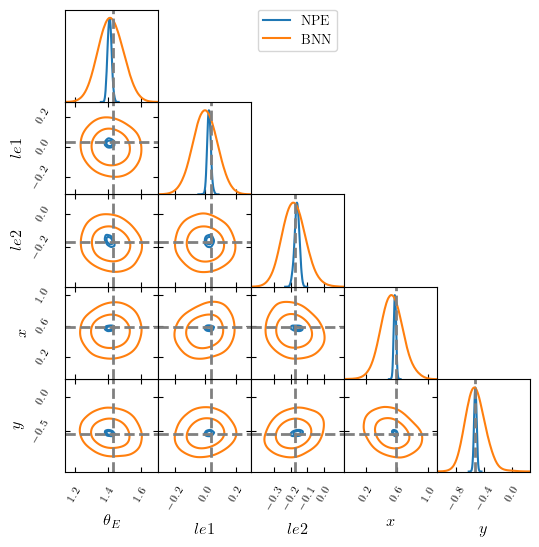

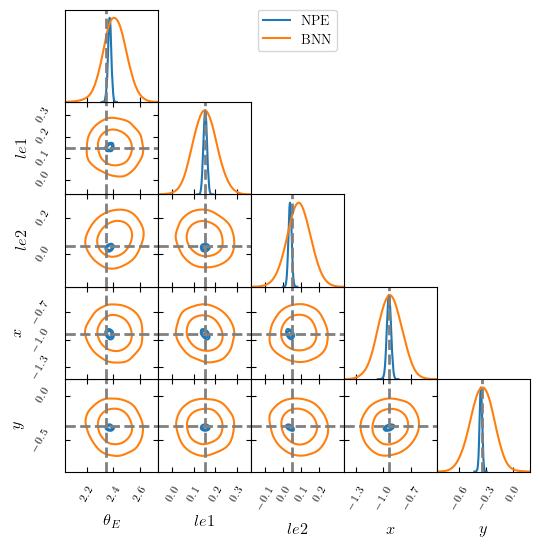

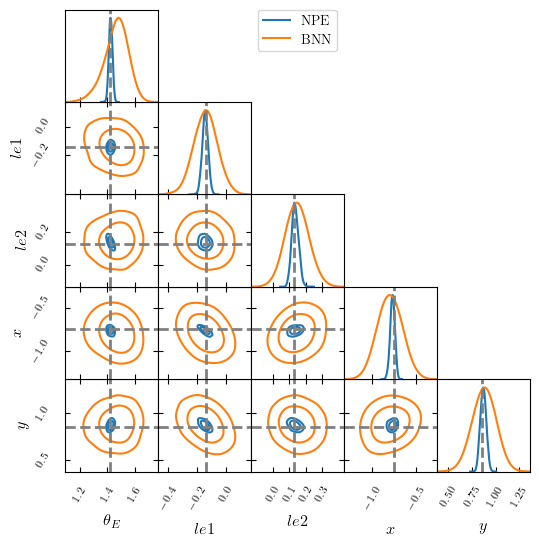

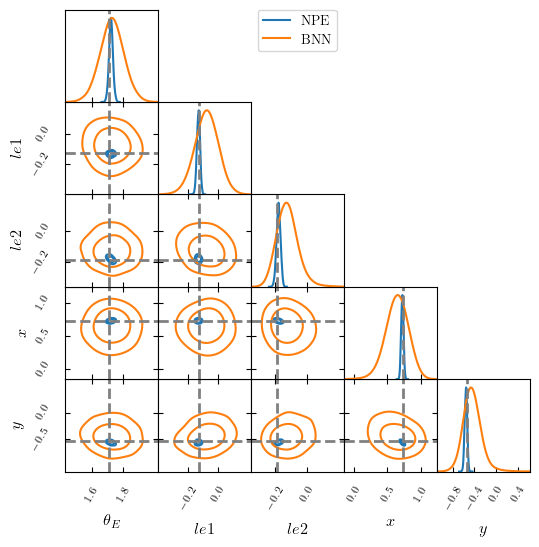

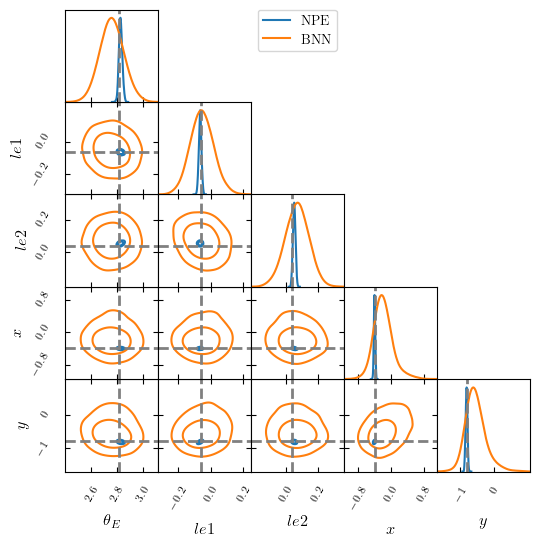

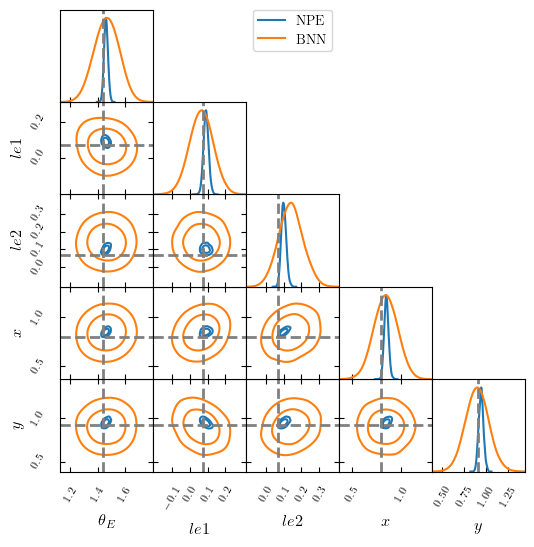

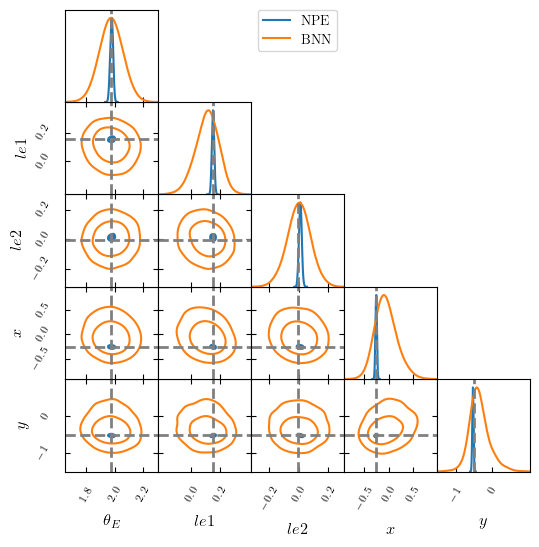

In [33]:
plot_pretty()
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

seed = 465
test_number = 1000
weird_index = [[0,1,2,3,8,9,10]]
# weird_index = [[2]]
prior_low = [0.3, -0.2, -0.2, -1,-1]
prior_high = [4.0, 0.2, 0.2, 1, 1]

limits = np.array([prior_low, prior_high])

for i, index in enumerate(np.ravel(weird_index[0])):

  true_theta_E = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[index]
  true_le1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[index]
  true_le2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[index]
  true_x = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[index]
  true_y = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[index]

  sample_BNN = BNNsamples[:,index,:]
  samples = np.array(SBI_sample_array[0,index])
  logp = np.array(SBI_logp_array[0,index])
  # map = np.array(SBI_map_array[0,index])
  best_fit_t = SBI_best_fit_arr[0,index,:]
  max_like_t = SBI_max_like_arr[0,index,:]

  config_file_lens = '../SBI_WG/5param_model_test.yaml'
  test_set_model = dl.make_dataset(config_file_lens, return_planes=True)

  config_file_source = '../SBI_WG/5param_model_test_source.yaml'
  source_set_model = dl.make_dataset(config_file_source, return_planes=True)

  SBIsingle = MCSamples(samples=np.array(samples),
                              names = [r'\theta_E',r'le1',r'le2',r'x',r'y'],
                        labels = [r'\theta_E',r'le1',r'le2',r'x',r'y'])
  BNNsingle = MCSamples(samples=sample_BNN,
                              names = [r'\theta_E',r'le1',r'le2',r'x',r'y'],
                        labels = [r'\theta_E',r'le1',r'le2',r'x',r'y'])

  g = plots.get_subplot_plotter(width_inch=6)
  g.settings.scaling_factor = 1
  g.settings.axes_fontsize=10
  g.settings.axis_tick_x_rotation=60
  g.settings.axis_tick_y_rotation=60
  g.settings.scaling_factor = 1
  g.settings.title_limit_labels = False
  g.settings.title_limit_fontsize = 10
  g.settings.axis_marker_lw = 2
  g.settings.tight_layout = False
  g.settings.constrained_layout = False
  g.triangle_plot([SBIsingle,BNNsingle],[r'\theta_E',r'le1',r'le2',r'x',r'y'], legend_labels=['NPE','BNN'],
                colors=['tab:blue','tab:orange'],
                contour_lws = [1.5,1.5],
                line_args=[{'color':'tab:blue'},{'color':'tab:orange'}],
                 marker_args ={'lw':2},
                  markers={r'\theta_E':true_theta_E,r'le1':true_le1,r'le2':true_le2,r'x':true_x,r'y':true_y},
                  title_limit=0)
  plt.savefig('5param_single_image_corner_%s_%s.pdf'%(seed,index),format='pdf')

Finally, output latex-friendly statistics to quote in documents.

In [34]:
weird_index = [[0,1,2,3,8,9,10]]

for i, index in enumerate(np.ravel(weird_index[0])):


  sample_BNN = BNNsamples[:,index,:]
  samples = np.array(SBI_sample_array[0,index])
  logp = np.array(SBI_logp_array[0,index])
  # map = np.array(SBI_map_array[0,index])
  best_fit_t = SBI_median_arr[0,index,:]
  max_like_t = SBI_max_like_arr[0,index,:]

  SBIsingle = MCSamples(samples=np.array(samples),
                              names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y'],
                        labels = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y'])

  BNNsingle = MCSamples(samples=sample_BNN,
                              names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y'],
                        labels = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y'])


  print(f"Weird index {index}")
  print(SBIsingle.getLatex(params=None, limit=1, err_sig_figs=None))
  print(SBIsingle.getLatex(params=None, limit=2, err_sig_figs=None))
  print(BNNsingle.getLatex(params=None, limit=1, err_sig_figs=None))
  print(BNNsingle.getLatex(params=None, limit=2, err_sig_figs=None))

Removed no burn in
Removed no burn in
Weird index 0
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y'], ['1.410\\pm 0.012', '0.024^{+0.011}_{-0.012}', '-0.162^{+0.016}_{-0.014}', '0.574\\pm 0.015', '-0.524\\pm 0.019'])
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y'], ['1.410^{+0.024}_{-0.023}', '0.024^{+0.024}_{-0.024}', '-0.162^{+0.028}_{-0.031}', '0.574^{+0.030}_{-0.029}', '-0.524^{+0.035}_{-0.038}'])
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y'], ['1.417\\pm 0.075', '-0.002\\pm 0.080', '-0.181\\pm 0.072', '0.54\\pm 0.15', '-0.52^{+0.13}_{-0.16}'])
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y'], ['1.42^{+0.15}_{-0.14}', '0.00^{+0.16}_{-0.16}', '-0.18^{+0.15}_{-0.14}', '0.54^{+0.30}_{-0.29}', '-0.52^{+0.30}_{-0.27}'])
Removed no burn in
Removed no burn in
Weird index 1
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y'], ['2.372\\pm 0.013', '0.1523\\pm 0.0083', '0.0370\\pm 0.0088', '-0.938\\pm 0.023', '-0.358\\pm 0.014'])
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y'], ['2.372^{+0.025}_{-0.026}', '0.152^{